In [57]:
import re
import os
import ytree
import glob
from tqdm import tqdm
import pandas as pd
import pynbody as pb
import matplotlib.pyplot as plt 
from multiprocessing import Pool
import numpy as np
import yt

In [2]:
def extract_numeric_part(s):
    return int(s[-5:])

path_uhd = '/mnt/storage/_data/nihao/nihao_uhd'
sim_name = ['8.26e11_zoom_2_new_run/?.??e??.0????', 
            'g2.79e12_3x6/?.??e??.0????', 
            'g1.12e12_3x9/?.??e??.0????',
            'g6.96e11_3x9/?.??e??.0????',
            'g7.08e11_5x10/?.??e??.0????',
            'g7.55e11_3x9/?.??e??.0????']
#we want the last snapshot for each simulations, so the .0???? with the highest value
sim_path = [sorted(glob.glob(os.path.join(path_uhd, sim)), key=extract_numeric_part)[-1] for sim in sim_name   ]

#quick spot check
sim_path

['/mnt/storage/_data/nihao/nihao_uhd/8.26e11_zoom_2_new_run/8.26e11.02000',
 '/mnt/storage/_data/nihao/nihao_uhd/g2.79e12_3x6/2.79e12.02000',
 '/mnt/storage/_data/nihao/nihao_uhd/g1.12e12_3x9/1.12e12.02000',
 '/mnt/storage/_data/nihao/nihao_uhd/g6.96e11_3x9/6.96e11.01024',
 '/mnt/storage/_data/nihao/nihao_uhd/g7.08e11_5x10/7.08e11.01024',
 '/mnt/storage/_data/nihao/nihao_uhd/g7.55e11_3x9/7.55e11.01024']

In [108]:
path_ytree_files_z0 = [s+'.parameter' for s in sim_path]
path_ytree_files_z0 

i = 0
path_to_tree = path_ytree_files_z0[i]
single_tree = ytree.load(path_to_tree,  hubble_constant=0.67)
# fn = single_tree.save_arbor()
# single_tree = ytree.load(fn)

if i==0:
    single_tree.add_alias_field('mass','Mhalo',units='Msun/h')
# else:   
#     single_tree.add_alias_field('mass','Mvir',units='Msun')

In [110]:
def get_arbor_merge_history(isolated_TreeNode):
    
    df = pd.DataFrame(columns = ['merge_index', 'merge_header', 'merge_id', 'redshift', 'mass_merge_header', 
                                 'mass_progenitor_parallel_to_merge_header', 'file_path'])

    #first we get the main progenitor of the arbor, this is in root -> leaves order
    progenitor_root_to_leaves = list(isolated_TreeNode['prog'])

    #we want the leaves -> root order for all of our data
    progenitor_leaves_to_root = progenitor_root_to_leaves[::-1]
    
    merge_index = 0
    #now we prune the arbor and keep the branch that are not the progenitor of the arbor, we will need the index i
    for i in tqdm(range( len(progenitor_leaves_to_root)) ):
        #if the difference in the number of nodes bewteen two consecutive node in the progenitor_leaves_to_root is bigger than 1 it means that there is another branch:
        l_i = progenitor_leaves_to_root[i].tree_size
        l_i_old = progenitor_leaves_to_root[i-1].tree_size
        if l_i - l_i_old > 1:
            pruned_branches = [j for j in progenitor_leaves_to_root[i]['tree'] if j['uid'] not in progenitor_leaves_to_root[i-1]['tree', 'uid'] ]
            merge_header = [j for j in pruned_branches if j['redshift'] == progenitor_leaves_to_root[i-1]['redshift'] ]
            for m_h in merge_header:
                # if m_h not in list(isolated_TreeNode.get_leaf_nodes()) and len(list(m_h.ancestors)) != 0:
                #     df.loc[len(df)] = [merge_index, m_h, m_h['ID'], m_h['redshift'], m_h['mass'].to('Msun').value.item(), progenitor_leaves_to_root[i-1]['mass'],  list(m_h.ancestors)[0].data_file ]
                # else:  
                df.loc[len(df)] = [merge_index, m_h, m_h['ID'], m_h['redshift'], m_h['M_star'].item(), progenitor_leaves_to_root[i-1]['mass'],  m_h.data_file ]
            merge_index += 1

    return df

In [80]:
no_leaf = [a for a in list(single_tree[0]['prog']) if a not in list(single_tree[0].get_leaf_nodes())]

In [81]:
for node in no_leaf:
    print(node, list(node.ancestors))

TreeNode[0] [TreeNode[4784], TreeNode[7598], TreeNode[7737], TreeNode[7990], TreeNode[8474], TreeNode[8812], TreeNode[8867], TreeNode[8903], TreeNode[8928], TreeNode[9249], TreeNode[9326], TreeNode[9417], TreeNode[9421], TreeNode[9423], TreeNode[9478]]
TreeNode[4784] [TreeNode[9559], TreeNode[10952], TreeNode[11450], TreeNode[11913], TreeNode[11949], TreeNode[14012], TreeNode[14236], TreeNode[14241], TreeNode[14266]]
TreeNode[9559] [TreeNode[14343], TreeNode[15031], TreeNode[15791], TreeNode[17936], TreeNode[18535], TreeNode[19065], TreeNode[19119], TreeNode[19126], TreeNode[19128]]
TreeNode[14343] [TreeNode[19133], TreeNode[19868], TreeNode[21388], TreeNode[22554], TreeNode[23132], TreeNode[23241], TreeNode[23526], TreeNode[23628], TreeNode[23651], TreeNode[23871]]
TreeNode[19133] [TreeNode[23946], TreeNode[24104], TreeNode[25294], TreeNode[25299], TreeNode[26324], TreeNode[27302]]
TreeNode[23946] [TreeNode[28755], TreeNode[31771], TreeNode[32400], TreeNode[32479], TreeNode[32951], Tr

In [86]:
df = get_arbor_merge_history(single_tree[0])

100%|██████████| 226/226 [20:11<00:00,  5.36s/it]


In [87]:
df

,merge_index,merge_header,merge_id,redshift,mass_merge_header,mass_progenitor_parallel_to_merge_header,file_path
0,0,TreeNode[1195154],20,12.126000,38286.1,465910000.0 Msun/h,/mnt/storage/_data/nihao/nihao_uhd/g2.79e12_3x...
1,0,TreeNode[1195196],62,12.126000,0.0,465910000.0 Msun/h,/mnt/storage/_data/nihao/nihao_uhd/g2.79e12_3x...
2,0,TreeNode[1195254],120,12.126000,0.0,465910000.0 Msun/h,/mnt/storage/_data/nihao/nihao_uhd/g2.79e12_3x...
3,0,TreeNode[1195264],130,12.126000,0.0,465910000.0 Msun/h,/mnt/storage/_data/nihao/nihao_uhd/g2.79e12_3x...
4,1,TreeNode[1194084],30,10.685100,135665.0,1928630000.0 Msun/h,/mnt/storage/_data/nihao/nihao_uhd/g2.79e12_3x...
...,...,...,...,...,...,...,...
3756,220,TreeNode[9326],4542,0.004755,0.0,2097010000000.0 Msun/h,/mnt/storage/_data/nihao/nihao_uhd/g2.79e12_3x...
3757,220,TreeNode[9417],4633,0.004755,0.0,2097010000000.0 Msun/h,/mnt/storage/_data/nihao/nihao_uhd/g2.79e12_3x...
3758,220,TreeNode[9421],4637,0.004755,0.0,2097010000000.0 Msun/h,/mnt/storage/_data/nihao/nihao_uhd/g2.79e12_3x...
3759,220,TreeNode[9423],4639,0.004755,0.0,2097010000000.0 Msun/h,/mnt/storage/_data/nihao/nihao_uhd/g2.79e12_3x...


In [46]:
df.head()

,merge_index,merge_header,merge_id,redshift,mass_merge_header,mass_progenitor_parallel_to_merge_header,file_path
0,0,TreeNode[1195154],20,12.1260,3.179791e+08,465910000.0 Msun/h,/mnt/storage/_data/nihao/nihao_uhd/g2.79e12_3x...
1,0,TreeNode[1195196],62,12.1260,1.758313e+08,465910000.0 Msun/h,/mnt/storage/_data/nihao/nihao_uhd/g2.79e12_3x...
2,0,TreeNode[1195254],120,12.1260,8.970313e+07,465910000.0 Msun/h,/mnt/storage/_data/nihao/nihao_uhd/g2.79e12_3x...
3,0,TreeNode[1195264],130,12.1260,1.105534e+08,465910000.0 Msun/h,/mnt/storage/_data/nihao/nihao_uhd/g2.79e12_3x...
4,1,TreeNode[1194084],30,10.6851,5.609119e+08,1928630000.0 Msun/h,/mnt/storage/_data/nihao/nihao_uhd/g2.79e12_3x...


In [7]:
# Define the pattern (replace z0.000 as needed)
# z_value = "z12.126"
# pattern = fr"(.*\.\d{{5}})\.{z_value}\.AHF_fpos"

# # Extract matches without the suffix
# results = [re.search(pattern, fname).group(1) for fname in os.listdir('/mnt/storage/_data/nihao/nihao_uhd/g2.79e12_3x6') if re.search(pattern, fname)]

# print(results)

In [88]:
da =  df.sort_values(by='mass_merge_header', ascending=False)
da.head()

,merge_index,merge_header,merge_id,redshift,mass_merge_header,mass_progenitor_parallel_to_merge_header,file_path
2890,161,TreeNode[300555],1,0.364532,3.530000e+09,2173290000000.0 Msun/h,/mnt/storage/_data/nihao/nihao_uhd/g2.79e12_3x...
3349,183,TreeNode[186800],2,0.208558,3.445490e+09,2168970000000.0 Msun/h,/mnt/storage/_data/nihao/nihao_uhd/g2.79e12_3x...
3306,180,TreeNode[202089],2,0.227970,3.441390e+09,2189060000000.0 Msun/h,/mnt/storage/_data/nihao/nihao_uhd/g2.79e12_3x...
3137,172,TreeNode[243114],1,0.282422,3.428210e+09,2261630000000.0 Msun/h,/mnt/storage/_data/nihao/nihao_uhd/g2.79e12_3x...
897,57,TreeNode[902403],1,2.098320,2.256490e+09,955041000000.0 Msun/h,/mnt/storage/_data/nihao/nihao_uhd/g2.79e12_3x...


In [96]:
def process_row(args, ):
    path, merge_id = args
    sim = pb.load(path)
    # sim.physical_units()
    halos = sim.halos()
    h = halos[merge_id]
    feh = h.s['feh']
    ofe = h.s['ofe']
    infall_time = h.properties['time'].in_units('Gyr')
    mass = h.s['mass'].sum().in_units('Msol')
    return feh, ofe, mass, infall_time

def distribute_operation(df, maximum_merger):
    with Pool(processes=os.cpu_count()) as pool:
        # results = pool.map(process_row, [df.iloc[i] for i in range(maximum_merger)])
        # df_new = df[df['mass_merge_header']<5e10]
        df_new = df
        df_new = df_new.sort_values(by='mass_merge_header', ascending=False)
        list_of_object = [(str(df_new.iloc[i]['file_path'])[:-10], df_new.iloc[i]['merge_id']+1) for i in range(maximum_merger)]
        results = pool.map(process_row, list_of_object)
        
            
    feh_list = [result[0] for result in results]
    ofe_list = [result[1] for result in results]
    mass_list = [result[2] for result in results]
    redsift_list = [result[3] for result in results]
    
    feh_concat = np.concatenate(feh_list)
    ofe_concat = np.concatenate(ofe_list)
    mass_concat = np.array(mass_list)
    infall_time_concat = np.array(redsift_list)
    
    
    return feh_concat, ofe_concat, mass_concat, infall_time_concat

pynbody.halo : An error occurred while reading substructure file. Falling back to using the halo info.
pynbody.halo : An error occurred while reading substructure file. Falling back to using the halo info.
pynbody.halo : An error occurred while reading substructure file. Falling back to using the halo info.
pynbody.halo : An error occurred while reading substructure file. Falling back to using the halo info.
pynbody.halo : An error occurred while reading substructure file. Falling back to using the halo info.
pynbody.halo : An error occurred while reading substructure file. Falling back to using the halo info.
pynbody.halo : An error occurred while reading substructure file. Falling back to using the halo info.
pynbody.halo : An error occurred while reading substructure file. Falling back to using the halo info.
pynbody.halo : An error occurred while reading substructure file. Falling back to using the halo info.
pynbody.halo : An error occurred while reading substructure file. Falling

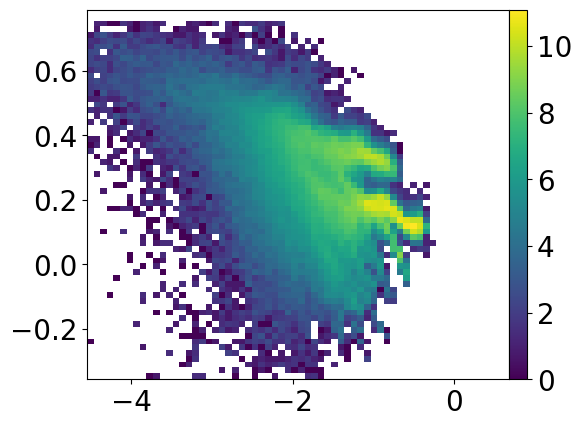

In [97]:
if __name__ == '__main__':
    preprocessin_file_training_set = np.load('/mnt/storage/giuseppe_data/data/casbi_rewriting/preprocess_file.npz', allow_pickle=True)
    min_feh, max_feh = np.percentile(preprocessin_file_training_set['FeH'], [0.1, 100])
    min_ofe, max_ofe = np.percentile(preprocessin_file_training_set['OFe'], [0.1, 100])
    
    feh, ofe, mass, infall_time = distribute_operation(df, 100)
    galaxy_2d_hist, _, _ = np.histogram2d(feh, ofe, bins=64, range=[[min_feh, max_feh], [min_ofe, max_ofe]])
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    im = ax.imshow(np.log(galaxy_2d_hist.T), origin='lower', extent=[min_feh, max_feh, min_ofe, max_ofe], aspect='auto', cmap='viridis', )
    ax.set_xlim(min_feh, max_feh)
    ax.set_ylim(min_ofe, max_ofe)
    # Set the font size of the ticks to 20
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    # Add colorbar to the top of each subplot
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', location='right', pad=0)
    cbar.ax.tick_params(labelsize=20)

In [113]:
path_to_tree[-23:-10]

'8.26e11.02000'

In [115]:
os.path.join('./file/', path_to_tree[-24:-10])

'/8.26e11.02000'

In [116]:
! pwd

/mnt/storage/giuseppe_data/CASBI/notebooks/nihao_uhd


In [98]:
def create_array(i, j):
    final_array = np.zeros((64, 64, 3))
    final_array[:, :, 0 ] =  galaxy_2d_hist
    final_array[:, :, 1] = i*np.ones_like(galaxy_2d_hist)
    final_array[:, :, 2] = j*np.ones_like(galaxy_2d_hist)
    
    return final_array

a = create_array(0, 1)

In [99]:
x = np.array([create_array(i, 1) for i in range(100)])

In [107]:
theta = np.zeros((100, 2))
theta[:, 0] = mass*0.67
theta[:, 1] = infall_time

theta

array([[3.52451407e+09, 9.68370985e+00],
       [3.44013354e+09, 1.12027265e+01],
       [3.43604470e+09, 1.09955879e+01],
       [3.42287836e+09, 1.04432182e+01],
       [2.25298355e+09, 3.12431974e+00],
       [2.04992815e+09, 2.98622731e+00],
       [1.53458341e+09, 2.64099625e+00],
       [7.30524993e+08, 8.44087804e+00],
       [5.07685085e+08, 9.89084849e+00],
       [4.78492723e+08, 1.00979871e+01],
       [4.54100087e+08, 2.08862656e+00],
       [3.77132202e+08, 1.06503568e+01],
       [3.31346938e+08, 2.36481141e+00],
       [2.13597025e+08, 2.64099625e+00],
       [2.07020148e+08, 5.74807578e+00],
       [1.94638808e+08, 1.09955879e+01],
       [1.90204729e+08, 2.71004247e+00],
       [1.74839114e+08, 1.08574955e+01],
       [1.67822020e+08, 2.77908868e+00],
       [1.53612342e+08, 3.33145837e+00],
       [1.40095759e+08, 9.89084849e+00],
       [1.05384497e+08, 4.64333639e+00],
       [8.46576768e+07, 2.22671898e+00],
       [8.26794970e+07, 8.44087804e+00],
       [7.480981